> # TODO
> - Use [lr_finder](https://towardsdatascience.com/estimating-optimal-learning-rate-for-a-deep-neural-network-ce32f2556ce0)
> - 10-fold crossvalidation
> - Use correct lr scheduler
> - 2nd train unfreezed (or partially unfreezed)
> - Balance the data
> - Metrics: mAP
> - Metrics: Confusion matrix
> - Try better models (resnet34, resnet50)
> - Bigger input size (480)
> - **Use libjpeg-turbo** or **PyVips** to speed up jpeg image I/O from the disk.
> - Use **albumentations**for GPU utilization.

> # DONE
> - Fix num_workers = 4  (no es posible en windows)
> - Set validation and test set and train
> - Metrics
>   - Loss
>   - Accuracy

# Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import pathlib
import PIL
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("PyTorch Version: ",torchvision.__version__)

# plt.xkcd();  # commic plots plt.rcdefaults() to disable

PyTorch Version:  0.4.1
PyTorch Version:  0.2.1


# Hyperparameters

In [2]:
batch_size      = 32
val_percent     = 0.3
num_workers     = 0  # 4 when is fixed
num_classes     = 4

model_name      = "resnet18"
pretrained      = True
num_epochs      = 8
learning_rate   = 0.001
momentum        = 0.9
weight_decay    = 1e-4

device          = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load data

In [3]:
csv_file = pathlib.Path("D:/Datasets/TFM/histologyDS2828/imageClasses.txt")
data_dir = pathlib.Path("D:/Datasets/TFM/histologyDS2828/imgs")

In [14]:
class histologyDataset(Dataset):

	def __init__(self, csv_file, data_dir, subset):
		self.labels       = pd.read_csv(csv_file, header=None, delim_whitespace=True)
		self.labels_map   = {0 : "conective tissue", 1 : "ephitelial tissue", 2 : "muscular tissue", 3 : "nervous tissue"};
		self.data_dir     = data_dir
		self.augmentation = subset == "train"

		self.center_crop = transforms.CenterCrop(224) # 480
		self.random_crop = transforms.RandomCrop(224) # 480
		self.random_resized_crop = transforms.RandomResizedCrop(224)
		self.random_hor_flip = transforms.RandomHorizontalFlip()
		self.random_ver_flip = transforms.RandomHorizontalFlip()
		self.to_tensor   = transforms.ToTensor()
		self.normalize   = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

	def __len__(self):
		return len(self.labels)

	def __getitem__(self, idx):
		img_name = data_dir / (self.labels.iloc[idx, 0])
		image    = PIL.Image.open(img_name)

		if self.augmentation:
			image = self.random_resized_crop(image)
			image = self.random_hor_flip(image)
			image = self.random_ver_flip(image)
		else:
			image  = self.center_crop(image)

		image  = self.to_tensor(image)
		#image  = self.normalize(image)

		label = self.labels.iloc[idx, 1] - 1

		return {"image": image, "label": label}

dataset = {x: histologyDataset(csv_file, data_dir, x) for x in ['train', 'val']}
dataloader = {x: DataLoader(dataset[x], batch_size=batch_size, shuffle=True, num_workers=num_workers) for x in ['train', 'val']}
dataset_sizes = {x: len(dataset[x]) for x in ['train', 'val']}
print("There are", dataset_sizes["val"], "images in the dataset.")

There are 2828 images in the dataset.


In [5]:
batch   = next(iter(dataloader["val"]))
inputs  = batch['image'].to(device)
classes = batch['label'].to(device)
print(inputs.size(), classes.size())

torch.Size([32, 3, 224, 224]) torch.Size([32])


# Check if data is balanced

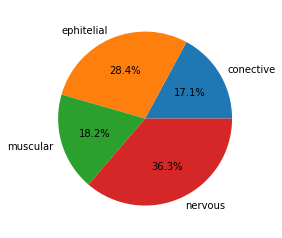

In [6]:
labels = 'conective', 'ephitelial', 'muscular', 'nervous'
count = [0, 0, 0, 0]

for i in range(len(dataset["val"])):
	class_number = dataset["val"].labels.iloc[i, 1]
	count[class_number-1] += 1

labels2 = [a+": "+str(b) for a, b in zip(labels, count)]
plt.pie(count, labels=labels, autopct='%1.1f%%');

# Show data

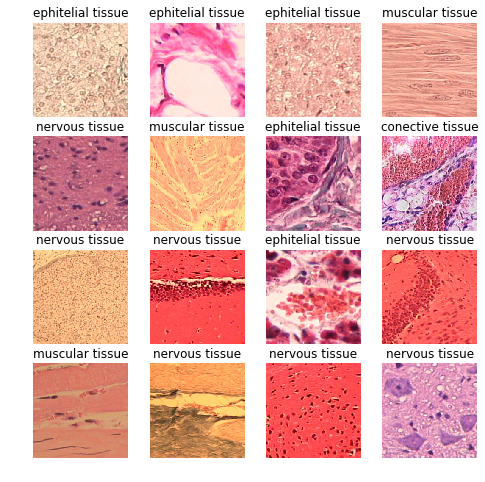

In [7]:
fig = plt.figure(figsize=(8,8));
columns = 4;
rows = 4;
for i in range(1, columns*rows +1):
    idx = np.random.randint(len(dataset["val"]));
    img = dataset["val"][idx]["image"]
    img = img.numpy().transpose((1, 2, 0))
    img = np.clip(img, 0, 1)
    
    fig.add_subplot(rows, columns, i)
    
    plt.title(dataset["val"].labels_map[dataset["val"][idx]["label"]])
    plt.axis('off')
    plt.imshow(img)
plt.show()

# Model: Resnet

In [8]:
model = torchvision.models.resnet18(pretrained=True)
input_size = 224

def freeze(model, freeze):
    if freeze:
        for param in model.parameters():
            param.requires_grad = False

# False: Finetune the whole model
# True:  Finetune the last layer
freeze(model, True)

model.fc   = nn.Linear(model.fc.in_features, num_classes) # new layer unfreezed by default


# Send the model to GPU
model = model.to(device)

print("Params to learn:")
params_to_update = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 fc.weight
	 fc.bias


# Train

In [15]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.SGD(params_to_update, lr=learning_rate, momentum=momentum)
#optimizer = optim.Adam(params_to_update, lr=learning_rate);

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

since = time.time()
best_acc = 0.0
#best_model_wts = copy.deepcopy(model.state_dict())

# Iterate epochs
for epoch in range(num_epochs):
	print('Epoch {}/{}'.format(epoch, num_epochs - 1))
	print('-' * 10)

	# Each epoch has a training and validation phase
	for phase in ['train', 'val']:
		if phase == 'train':
			scheduler.step() # Scheduling the learning rate
			model.train()    # Set model to training mode
		else:
			model.eval()     # Set model to evaluate mode

		running_loss     = 0.0
		running_corrects = 0

		# Iterate over data
		for i, batch in enumerate(dataloader[phase]):
			images = batch['image'].to(device)
			labels = batch['label'].to(device)

			optimizer.zero_grad()                  # zero the parameter gradients
			outputs = model(images)                # forward
			preds = torch.argmax(outputs, dim=1)   # prediction
			loss = criterion(outputs, labels)      # loss
			if phase == 'train': loss.backward()   # backward 
			if phase == 'train': optimizer.step()  # optimize

			# statistics
			running_loss     += loss.item() * inputs.size(0)
			running_corrects += torch.sum(preds == labels.data)

		epoch_loss = running_loss / dataset_sizes[phase]
		epoch_acc  = running_corrects.double() / dataset_sizes[phase]
		print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

		# deep copy the model
		if phase == 'val' and epoch_acc > best_acc:
			best_acc = epoch_acc
			#best_model_wts = copy.deepcopy(model.state_dict())
	print()

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed%60))
print('Best val Acc: {:4f}'.format(best_acc))

# load best model weights
#model.load_state_dict(best_model_wts)

Epoch 0/7
----------
train Loss: 0.7832 Acc: 0.7008
val Loss: 0.7680 Acc: 0.7037

Epoch 1/7
----------
train Loss: 0.7097 Acc: 0.7426
val Loss: 0.7058 Acc: 0.7334

Epoch 2/7
----------
train Loss: 0.6509 Acc: 0.7641
val Loss: 0.6852 Acc: 0.7465

Epoch 3/7
----------
train Loss: 0.6470 Acc: 0.7606
val Loss: 0.6552 Acc: 0.7652

Epoch 4/7
----------
train Loss: 0.6135 Acc: 0.7815
val Loss: 0.6335 Acc: 0.7712

Epoch 5/7
----------
train Loss: 0.5981 Acc: 0.7850
val Loss: 0.6302 Acc: 0.7709

Epoch 6/7
----------
train Loss: 0.5822 Acc: 0.7924
val Loss: 0.6244 Acc: 0.7790

Epoch 7/7
----------
train Loss: 0.5717 Acc: 0.7885
val Loss: 0.6082 Acc: 0.7818

Training complete in 4m 33s
Best val Acc: 0.781825


# Confusion matrix

In [ ]:
classes = 'conective', 'ephitelial', 'muscular', 'nervous'

batch   = next(iter(dataloader))
images = batch['image'].to(device)
labels = batch['label'].to(device)
outputs = model(images)           # forward

y_true = labels.cpu().numpy()
y_pred = torch.argmax(outputs, dim=1).cpu().numpy()
_, y_pred2 = torch.max(outputs, 1).cpu().numpy()

cm = confusion_matrix(y_true, y_pred)
print(y_true)
print(y_pred)
print(y_pred2)
print(cm)

#plt.matshow(cm)
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, cm[i, j], fontsize=18, horizontalalignment="center", color="white")
plt.tight_layout()